This is a jupyter notebook designed to run the full cell counting pipeline piece by piece to test each individual section. Full implementation of the pipeline can be found in FinalPipeline.py

In [45]:
import numpy as np
import tifffile
import cv2
import json

import torch
import torch.nn as nn
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt
 

class ImageProcessor:
    def __init__(self, model_path='path_to_pretrained_model.pth'):
        # Load the pretrained EfficientNet model
        self.NN = EfficientNet.from_pretrained("efficientnet-b7", advprop=False)

        # Load the state dictionary of the custom model
        #custom_model_state_dict = torch.load(model_path)

        # Replace the classifier in the EfficientNet model with the custom classifier
        #self.NN.classifier.load_state_dict(custom_model_state_dict['classifier'])

        # Freeze the weights of the pre-trained model
        for param in self.NN.parameters():
            param.requires_grad = False

        # Assuming 'transform' is a torchvision.transforms object for preprocessing
        self.transform = transforms.Compose([
            transforms.ToTensor(),  
            transforms.RandomHorizontalFlip(0.4),
            transforms.RandomVerticalFlip(0.4),
            transforms.RandomInvert(0.7),
            transforms.RandomRotation(35),
            transforms.ToTensor(),
        ])

    def process_image(self, image_path):
        # Load the image from the .tif file
        image = tifffile.imread(image_path)

        # Apply your defined function to separate slices
        droplet_segments, x_coordinates = self.identify_droplet_segments(image)

        # Initialize an empty list to store cell counts and x coordinates
        results = []

        # Iterate over slices and pass through the pretrained neural network
        for i, slice in enumerate(droplet_segments):
            print(slice)
            input_tensor = self.transform(slice)
            input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension

            with torch.no_grad():
                output = self.NN(input_tensor)

            cell_count = output.item()

            # Append results to the list
            results.append({"x_coordinate": x_coordinates[i], "cell_count": cell_count})

        return results

    def identify_droplet_segments(self, image):

        # 1. Convert the image to greyscale
        grey_image = np.dot(image[..., :3], [0.299, 0.587, 0.114])

        # 2. Apply filtering
        sobel_filtered_image = self.sobel_filter(grey_image)

        # 3. Apply slice on x to get a list of the slices
        segments_x = self.slice_along_x(sobel_filtered_image)

        #setup segments
        image_segments = []
        mean_x_value = []

        for segment_x in segments_x:
            coordinates_y = self.slice_along_y(sobel_filtered_image, segment_x)
            print(segment_x, coordinates_y)
            image_segments = []
            for coord_y in coordinates_y:
                original_segment = image[segment_x[0]:segment_x[1], coord_y[0]:coord_y[1]]
                image_segments.append(original_segment)

        return image_segments, mean_x_value

    def sobel_filter(self, gray_arr):
        # Apply Sobel filter to the image
        sobel_x = cv2.Sobel(gray_arr, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(gray_arr, cv2.CV_64F, 0, 1, ksize=3)
        mask = np.sqrt(sobel_x**2 + sobel_y**2)
        return mask

    def slice_along_x(self, image, threshold_start=45, threshold_end=45, min_segment_length=300, max_segment_length=600):

        # Calculate variance along the x-axis
        x_variances = np.mean(image, axis=0)

        # Identify segments where the variance exceeds the threshold
        segments = []
        droplet_started = False
        start_index = 0

        for i, value in enumerate(x_variances):
            if value > threshold_start and not droplet_started:
                droplet_started = True
                start_index = i
            elif value <= threshold_end and droplet_started:
                droplet_started = False
                end_index = i - 1
                segment_length = end_index - start_index

                # Check if the segment length is within the desired range
                if min_segment_length <= segment_length <= max_segment_length:
                    segments.append((start_index, end_index))

        # If a droplet continues to the end of the image, consider it
        if droplet_started:
            end_index = len(x_variances) - 1
            segment_length = end_index - start_index

            # Check if the segment length is within the desired range
            if min_segment_length <= segment_length <= max_segment_length:
                segments.append((start_index, end_index))

        # Extract slices based on the identified positions
        coordinates = [(start, end) for start, end in segments]

        return coordinates

    def slice_along_y(self, image, coordinates, y_threshold_start=40, y_threshold_end=40, min_segment_length=300, max_segment_length=600):

        # Calculate variance along the x-axis
        image = image[coordinates[0]:coordinates[1]]
        y_variances = np.mean(image, axis=1)

        # Identify segments where the variance exceeds the threshold
        segments = []
        droplet_started = False
        start_index = 0

        for i, value in enumerate(y_variances):
            if value > y_threshold_start and not droplet_started:
                droplet_started = True
                start_index = i
            elif value <= y_threshold_end and droplet_started:
                droplet_started = False
                end_index = i - 1
                segment_length = end_index - start_index

                # Check if the segment length is within the desired range
                if min_segment_length <= segment_length <= max_segment_length:
                    segments.append((start_index, end_index))

        # If a droplet continues to the end of the image, consider it
        if droplet_started:
            end_index = len(y_variances) - 1
            segment_length = end_index - start_index

            # Check if the segment length is within the desired range
            if min_segment_length <= segment_length <= max_segment_length:
                segments.append((start_index, end_index))

        # Extract slices based on the identified positions
        coordinates_y = [(start, end) for start, end in segments]

        return coordinates_y

# Example usage:
if __name__ == "__main__":

    inputPath = ""
    outputPath = ""
    DropletPositions = []
    CellCounts = []

    # TO ADD: for loop here, looping through each file in inputPath
    image_path = "../Data/Input/15.tif"
    image_processor = ImageProcessor()
    results = image_processor.process_image(image_path)

    # Append results to Droplet Positions and Cell Counts
    for result in results:
        DropletPositions.append(result["x_coordinate"])
        CellCounts.append(result["cell_count"])

    # After: Create a json file from DropletPositions and Cell Counts, Sequence Number, Frame Number
    output_data = {
        "DropletPositions": DropletPositions,
        "CellCounts": CellCounts,
        # Add other relevant information
    }

    # Save results to a .json file
    with open('output.json', 'w') as json_file:
        json.dump(output_data, json_file)


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


Loaded pretrained weights for efficientnet-b7
(0, 364) []
(464, 1051) [(0, 457)]
(1131, 1711) []


In [ ]:
import numpy as np
import tifffile
import cv2
import json
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
import segmentation_models_pytorch as smp

""""""
class SegmentationAndRegressionModel(nn.Module):
    def __init__(self, encoder_name="efficientnet-b0", encoder_weights="imagenet"):
        super(SegmentationAndRegressionModel, self).__init__()
        self.unet = smp.Unet(encoder_name, encoder_weights=encoder_weights, in_channels=1, classes=1)
        for param in self.unet.parameters(): #freeze params for speed
            param.requires_grad = False

        self.mlp = nn.Sequential(
            nn.Linear(16384, 512), 
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        seg_output = self.unet(x)
        mlp_input = seg_output.view(seg_output.size(0), -1)  # Flatten
        regression_output = self.mlp(mlp_input)
        return regression_output


    
class ImageProcessor:
    def __init__(self, model_path='../Data/model_efficientNetB7.pt'):
        # Load the cell count model
        self.segmentation_and_regression_model = SegmentationAndRegressionModel()
        state_dict = torch.load(model_path)
        self.segmentation_and_regression_model.load_state_dict(state_dict)
        self.segmentation_and_regression_model.eval()
       
        self.transform = transforms.Compose([
            transforms.ToPILImage(),  
            transforms.Resize((128, 128)),  # Resize the image for consistant input shape
            transforms.ToTensor(), 
        ])

    def process_image(self, image_path):
        # Load the image from the .tif file
        image = tifffile.imread(image_path)

        # Apply your defined function to separate slices
        droplet_segments, x_coordinates = self.identify_droplet_segments(image)

        # Initialize an empty list to store cell counts and x coordinates
        results = []

        # Iterate over slices and pass through the pretrained neural network
        for i, slice in enumerate(droplet_segments):
            droplet_segment_tensor = self.transform(slice)
            print(droplet_segment_tensor)

            with torch.no_grad():
                output_cell_count = self.segmentation_and_regression_model(droplet_segment_tensor)

            # Extract ouput
            cell_count = torch.sum(output_cell_count).item()

            # Append results to the list
            results.append({"x_coordinate": x_coordinates[i], "cell_count": cell_count})

            return results

    def identify_droplet_segments(self, image):

        # 1. Convert the image to greyscale
        grey_image = np.dot(image[..., :3], [0.299, 0.587, 0.114])

        # 2. Apply filtering
        sobel_filtered_image = self.sobel_filter(grey_image)

        # 3. Apply slice on x to get a list of the slices
        segments_x = self.slice_along_x(sobel_filtered_image)

        # setup segments
        image_segments = []
        mean_x_value = []

        for segment_x in segments_x:
            coordinates_y = self.slice_along_y(image = sobel_filtered_image, coordinates= segment_x)
            original_segment = grey_image[coordinates_y[0][0]:coordinates_y[0][1],segment_x[0]:segment_x[1]]
            original_segment = original_segment.astype(int)
            self.visualize_image(original_segment)
            image_segments.append(original_segment)

        return image_segments, mean_x_value

    def visualize_image(self, image):
        plt.imshow(image, cmap='gray')
        plt.show()

    def sobel_filter(self, gray_arr):
        # Apply Sobel filter to the image
        sobel_x = cv2.Sobel(gray_arr, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(gray_arr, cv2.CV_64F, 0, 1, ksize=3)
        mask = np.sqrt(sobel_x**2 + sobel_y**2)
        return mask

    def slice_along_x(self, image, threshold_start=40, threshold_end=40, min_segment_length=500, max_segment_length=800):
        # Calculate variance along the x-axis
        x_variances = np.mean(image, axis=0)

        # Identify segments where the variance exceeds the threshold
        segments = []
        droplet_started = False
        start_index = 0

        for i, value in enumerate(x_variances):
            if value > threshold_start and not droplet_started:
                droplet_started = True
                start_index = i
            elif value <= threshold_end and droplet_started:
                droplet_started = False
                end_index = i - 1
                segment_length = end_index - start_index

                # Check if the segment length is within the desired range
                if min_segment_length <= segment_length <= max_segment_length:
                    segments.append((start_index, end_index))

        # If a droplet continues to the end of the image, consider it
        if droplet_started:
            end_index = len(x_variances) - 1
            segment_length = end_index - start_index

            # Check if the segment length is within the desired range
            if min_segment_length <= segment_length <= max_segment_length:
                segments.append((start_index, end_index))

        # Extract slices based on the identified positions
        coordinates = [(start, end) for start, end in segments]

        return coordinates

    def slice_along_y(self, image, coordinates, y_threshold_start=40, y_threshold_end=40,
                      min_segment_length=450, max_segment_length=800):
        # Calculate variance along the x-axis
        image = image[:,coordinates[0]:coordinates[1]]
        y_variances = np.mean(image, axis=1)

        # Identify segments where the variance exceeds the threshold
        segments = []
        droplet_started = False
        start_index = 0

        for i, value in enumerate(y_variances):
            if value > y_threshold_start and not droplet_started:
                droplet_started = True
                start_index = i
            elif value <= y_threshold_end and droplet_started:
                droplet_started = False
                end_index = i - 1
                segment_length = end_index - start_index

                # Check if the segment length is within the desired range
                if min_segment_length <= segment_length <= max_segment_length:
                    segments.append((start_index, end_index))

        # Extract slices based on the identified positions
        coordinates_y = [(start, end) for start, end in segments]

        return coordinates_y


# Example usage:
if __name__ == "__main__":
    inputPath = ""
    outputPath = ""
    DropletPositions = []
    CellCounts = []

    # TO ADD: for loop here, looping through each file in inputPath
    image_path = "../Data/Input/15.tif"
    image_processor = ImageProcessor()
    results = image_processor.process_image(image_path)

    # Append results to Droplet Positions and Cell Counts
    for result in results:
        DropletPositions.append(result["x_coordinate"])
        CellCounts.append(result["cell_count"])


    # After: Create a json file from DropletPositions and Cell Counts, Sequence


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


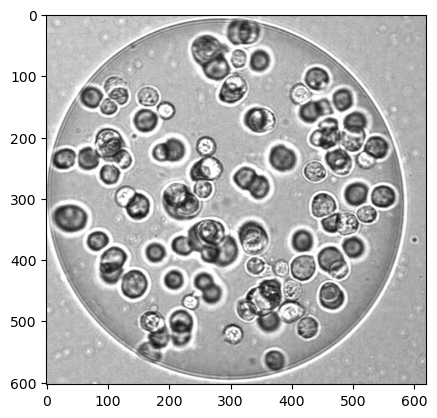

[772.5]


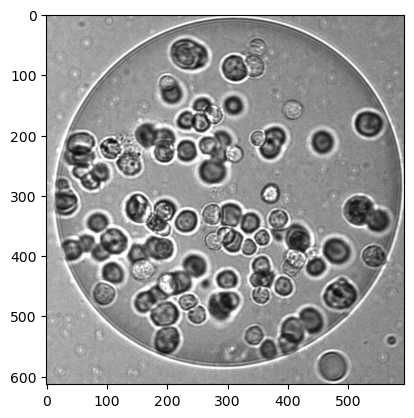

[772.5, 1415.0]
[[196 201 196 ... 171 164 176]
 [210 187 197 ... 175 172 173]
 [198 196 196 ... 178 167 181]
 ...
 [183 175 181 ... 176 177 168]
 [186 186 182 ... 160 181 175]
 [186 197 193 ... 180 170 168]]


In [14]:
import numpy as np
import tifffile
import cv2
import json
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import models, transforms
from efficientnet_pytorch import EfficientNet
import segmentation_models_pytorch as smp

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

""""""
NN = models.efficientnet_b7(weights="IMAGENET1K_V1")

#resnet not trained later 
for param in NN.parameters():
    param.requires_grad = False
    
num_features = NN.classifier[-1].in_features
    
mlp = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(512, 64),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(64, 1),
    #nn.Softmax(dim=1)
)

NN.classifier = mlp
    
class ImageProcessor:
    def __init__(self, model_path='../Data/model_efficientNetB7.pt'):
        # Load the cell count model
        #self.segmentation_and_regression_model = NN
        #state_dict = torch.load(model_path)
        #self.segmentation_and_regression_model.load_state_dict(state_dict)
        #self.segmentation_and_regression_model.eval()
       
        self.transform = transforms.Compose([
            transforms.ToPILImage(),  
            transforms.Resize((128, 128)),  # Resize the image for consistant input shape
            transforms.ToTensor(), 
        ])

    def process_image(self, image_path):
        # Load the image from the .tif file
        image = tifffile.imread(image_path)

        # Apply your defined function to separate slices
        droplet_segments, x_coordinates = self.identify_droplet_segments(image)

        # Initialize an empty list to store cell counts and x coordinates
        results = []

        # Iterate over slices and pass through the pretrained neural network
        for i, slice in enumerate(droplet_segments):
            #droplet_segment = cv2.resize(slice, (128,128), interpolation = cv2.INTER_LINEAR)
            #droplet_segment_tensor = torch.from_numpy(droplet_segment)
            print(slice)

            with torch.no_grad():
                #output_cell_count = self.segmentation_and_regression_model(droplet_segment_tensor)

            # Extract ouput
            #cell_count = torch.sum(output_cell_count).item()
                cell_count = 0

            # Append results to the list
            results.append({"x_coordinate": x_coordinates[i], "cell_count": cell_count})

            return results

    def identify_droplet_segments(self, image):

        # 1. Convert the image to greyscale
        grey_image = image[:,:,1]

        # 2. Apply filtering
        sobel_filtered_image = self.sobel_filter(grey_image)

        # 3. Apply slice on x to get a list of the slices
        segments_x = self.slice_along_x(sobel_filtered_image)

        # setup segments
        image_segments = []
        mean_x_value = []

        for segment_x in segments_x:
            coordinates_y = self.slice_along_y(image = sobel_filtered_image, coordinates= segment_x)
            original_segment = grey_image[coordinates_y[0][0]:coordinates_y[0][1],segment_x[0]:segment_x[1]]
            original_segment = original_segment.astype(int)
            self.visualize_image(original_segment)
            mean_x_value.append(np.mean(segment_x))
            print(mean_x_value)
            image_segments.append(original_segment)

        return image_segments, mean_x_value

    def visualize_image(self, image):
        plt.imshow(image, cmap='gray')
        plt.show()

    def sobel_filter(self, gray_arr):
        # Apply Sobel filter to the image
        sobel_x = cv2.Sobel(gray_arr, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(gray_arr, cv2.CV_64F, 0, 1, ksize=3)
        mask = np.sqrt(sobel_x**2 + sobel_y**2)
        return mask

    def slice_along_x(self, image, threshold_start=40, threshold_end=40, min_segment_length=500, max_segment_length=800):
        # Calculate variance along the x-axis
        x_variances = np.mean(image, axis=0)

        # Identify segments where the variance exceeds the threshold
        segments = []
        droplet_started = False
        start_index = 0

        for i, value in enumerate(x_variances):
            if value > threshold_start and not droplet_started:
                droplet_started = True
                start_index = i
            elif value <= threshold_end and droplet_started:
                droplet_started = False
                end_index = i - 1
                segment_length = end_index - start_index

                # Check if the segment length is within the desired range
                if min_segment_length <= segment_length <= max_segment_length:
                    segments.append((start_index, end_index))

        # If a droplet continues to the end of the image, consider it
        if droplet_started:
            end_index = len(x_variances) - 1
            segment_length = end_index - start_index

            # Check if the segment length is within the desired range
            if min_segment_length <= segment_length <= max_segment_length:
                segments.append((start_index, end_index))

        # Extract slices based on the identified positions
        coordinates = [(start, end) for start, end in segments]

        return coordinates

    def slice_along_y(self, image, coordinates, y_threshold_start=40, y_threshold_end=40,
                      min_segment_length=450, max_segment_length=800):
        # Calculate variance along the x-axis
        image = image[:,coordinates[0]:coordinates[1]]
        y_variances = np.mean(image, axis=1)

        # Identify segments where the variance exceeds the threshold
        segments = []
        droplet_started = False
        start_index = 0

        for i, value in enumerate(y_variances):
            if value > y_threshold_start and not droplet_started:
                droplet_started = True
                start_index = i
            elif value <= y_threshold_end and droplet_started:
                droplet_started = False
                end_index = i - 1
                segment_length = end_index - start_index

                # Check if the segment length is within the desired range
                if min_segment_length <= segment_length <= max_segment_length:
                    segments.append((start_index, end_index))

        # Extract slices based on the identified positions
        coordinates_y = [(start, end) for start, end in segments]

        return coordinates_y


# Example usage:
if __name__ == "__main__":
    inputPath = ""
    outputPath = ""
    DropletPositions = []
    CellCounts = []

    # TO ADD: for loop here, looping through each file in inputPath
    image_path = "../Data/Input/15.tif"
    tif_example = tifffile.imread(image_path)
    image_processor = ImageProcessor()
    results = image_processor.process_image(image_path)

    # Append results to Droplet Positions and Cell Counts
    for result in results:
        DropletPositions.append(result["x_coordinate"])
        CellCounts.append(result["cell_count"])


    # After: Create a json file from DropletPositions and Cell Counts, Sequence
